# Sentiment Analysis on Movie Reviews

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
import re
from time import time

from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

import pickle

warnings.simplefilter("ignore")

## Reading tsv

In [2]:
data = pd.read_csv("train.tsv",sep="\t", index_col=0)

## Defining Some Funcions

In [3]:
# Function to calculate Purity of reviews (Exploratory Data Analysis) 
def calculate_purity_of_review(sentiment_list):
    # Analysing Purity of each text, splited in N sentences
    # This calculus was based in PUR (CAO et al., 2006)
    count = Counter(sentiment_list) 
    maxi = max(count.values())
    PUR = (maxi / len(sentiment_list))
    return PUR

#Function to print stats from PUR
def pur_analysis(df1):
    #PUR analysis
    display(df1.head(3))
    print("Average: {}".format(df1['PUR'].mean()))
    print("Standard Dev: {}".format(df1['PUR'].std()))
    print("Max: {}".format(df1['PUR'].max()))
    print("min: {}".format(df1['PUR'].min()))
    worst_pur = df1[df1['PUR'] == df1['PUR'].min()].index[0]
    print("Exemple of worst_pur PUR review Sentiments: {}".format(df1.loc[worst_pur,'sentiment_list']))
    print("Exemple of worst_pur PUR review: {}".format(Counter(df1.loc[worst_pur,'sentiment_list'])))

# Create tag to remove empty lists
def identify_empty(x):
    if x == []:
        return 0
    else:
        return 1

# Create Function to get sentence and return stemmed sentence
def stemSentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(porter.stem(word))
    return stem_sentence

# Function to plot Chi² Best Features
def plot_chi2(x, y):
    chi2score = chi2(x, y)[0]
    wscores = zip(tvec.get_feature_names(), chi2score)
    wchi2 = sorted(wscores, key=lambda x:x[1])
    topchi2 = wchi2[::-1][:40]
    labels =  np.array(topchi2)[:,0]
    
    y_pos = range(0,len(topchi2))
    plt.figure(figsize=(8,7))
    chi_values = [round(float(i),2) for i in list(np.array(topchi2)[:,1])]

    plt.bar(y_pos, chi_values , align='center', alpha=0.5)
    plt.xticks(y_pos, np.array(topchi2)[:,0],rotation='vertical')
    plt.plot(y_pos, chi_values, '-o', markersize=5, alpha=0.8)
    plt.ylabel('Chi2')
    plt.xlabel('Top tokens')
    plt.title('Top tokens')
    plt.show()
    
def evaluate_model(clf,x,y):
    predictions = clf.predict(x)
    pred_proba = clf.predict_proba(x)

    print("mean_squared_error: {}".format(mean_squared_error(y, predictions)))
    print("accuracy_score: {}".format(accuracy_score(y, predictions)))
    report = classification_report(y, predictions)
    print(report)

    skplt.metrics.plot_confusion_matrix(y_true=y, y_pred=predictions)
    plt.show()

    skplt.metrics.plot_roc(y, pred_proba)
    plt.show()
    
# Utility function to report best scores (Randomize Search)
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# Exploratory Data Analysis

## Basic data view / Basic Statistics

In [4]:
display(data.describe())
display(data.head(3))
print(data.SentenceId.value_counts().head(3))
print(data.Sentiment.value_counts())

,SentenceId,Sentiment
count,156060.000000,156060.000000
mean,4079.732744,2.063578
std,2502.764394,0.893832
min,1.000000,0.000000
25%,1861.750000,2.000000
50%,4017.000000,2.000000
75%,6244.000000,3.000000
max,8544.000000,4.000000


,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series of escapades demonstrating the adage ...,1
2,1,A series of escapades demonstrating the adage ...,2
3,1,A series,2


1       63
5555    63
509     59
Name: SentenceId, dtype: int64
2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64


## Analyze Purity of Reviews

In [5]:
# Are there reviews with more than one type of sentiment?
# Do these reviews have much variation in sentiment?
# Is it better to use the whole review or just each sentence?
# Analysing reviews with more than one sentiment:

# Creating DataSet to do Analysis
df1 = data.groupby('SentenceId')['Sentiment'].apply(list).reset_index(name='sentiment_list')

# Applying function to get PUR
df1['PUR'] = df1.sentiment_list.apply(lambda x: calculate_purity_of_review(x))
pur_analysis(df1)

# Analyze Purity considering fewer classes
# Creating DataSet to do Analysis
df1 = data.copy()
df1.loc[df1['Sentiment'] == 1, 'Sentiment'] = 0
df1.loc[df1['Sentiment'] == 3, 'Sentiment'] = 4
df1 = df1.groupby('SentenceId')['Sentiment'].apply(list).reset_index(name='sentiment_list')

# Applying function to get PUR
df1['PUR'] = df1.sentiment_list.apply(lambda x: calculate_purity_of_review(x))
pur_analysis(df1)

,SentenceId,sentiment_list,PUR
0,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.888889
1,2,"[4, 3, 2, 4, 3, 2, 3, 3, 3, 2, 2, 4, 2, 3, 4, ...",0.444444
2,3,"[1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, ...",0.714286


Average: 0.5860771031007298
Standard Dev: 0.15336136016795418
Max: 1.0
min: 0.2222222222222222
Exemple of worst_pur PUR review Sentiments: [0, 2, 2, 1, 0, 1, 3, 4, 4]
Exemple of worst_pur PUR review: Counter({0: 2, 2: 2, 1: 2, 4: 2, 3: 1})


,SentenceId,sentiment_list,PUR
0,1,"[0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.888889
1,2,"[4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 2, 4, 2, 4, 4, ...",0.555556
2,3,"[0, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, ...",0.714286


Average: 0.6453707284983116
Standard Dev: 0.15171871808693688
Max: 1.0
min: 0.3333333333333333
Exemple of worst_pur PUR review Sentiments: [4, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2]
Exemple of worst_pur PUR review: Counter({4: 11, 0: 11, 2: 11})


## View WordCloud

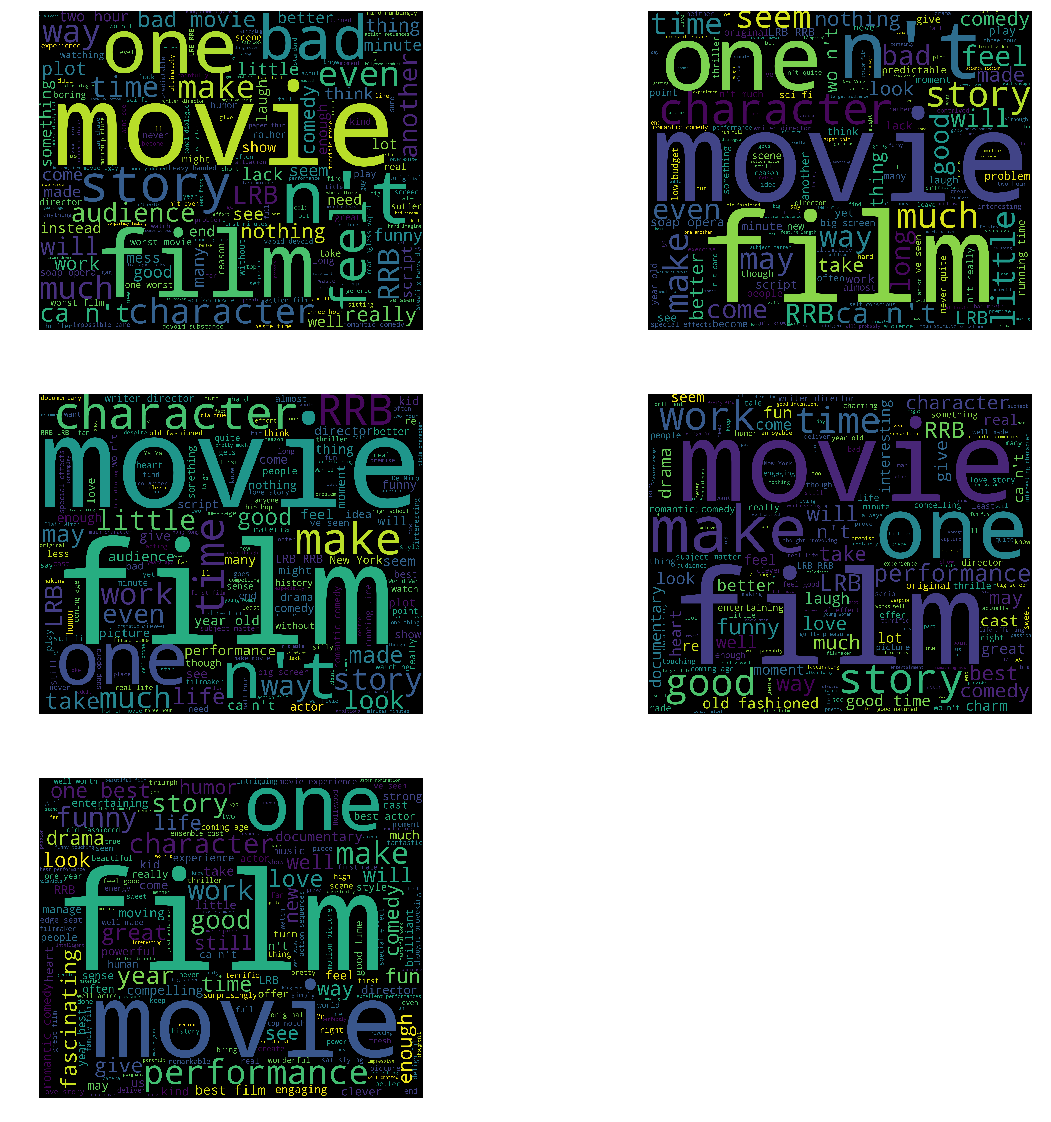

In [6]:
# Show one word cloud to each Sentiment
d = {}
plt.figure(1,figsize=(20, 20))
for i in range(0,5):
    d[i] = data[data.Sentiment==i]
    words = ' '.join(d[i]['Phrase'])
    split_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(background_color='black',width=3000,height=2500).generate(split_word)
    plt.subplot(320+(i+1))
    plt.imshow(wordcloud)
    plt.axis('off')
plt.show()

# Data Preprocessing
## Steps in Preprocessing Data
1. Drop Duplicates
2. Fill NaN
3. Drop NaN
4. Removing StopWords
5. To Lowercase
6. Tokenizer Data 
7. Removing Ponctuation
8. Removing Empty Values
9. Stemmer Data (reducing the different forms of a word to one single form)
10. Stratifying Data (split in train and test)

In [7]:
# Drop Duplicates
data = data.drop_duplicates()

# Fill NaN
data = data.fillna(method='ffill')

# Drop NaN
data.dropna(subset=['Phrase', 'Sentiment'])

# Removing StopWords
stop = stopwords.words('english')
data['Phrase'] = data.Phrase.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
display(data.head(2))

# to Lower Data
data['Phrase'] = data.Phrase.apply(lambda x: x.lower())

# Tokenizer Data
data['Phrase'] = data.Phrase.apply(lambda x: word_tokenize(x))

# Removing Ponctuation
#nonPunct = re.compile('.*[A-Za-z0-9].*')  # must contain a letter or digit
nonPunct = re.compile('.*[A-Za-z].*')  # must contain a letter
data['Phrase'] = data.Phrase.apply(lambda x: [w for w in x if nonPunct.match(w)])
display(data.head(2))

# Removing Empty Values (post pre-processing)
data['to_remove'] = data.Phrase.apply(lambda x: identify_empty(x))
data = data[data.to_remove == 1]

# Stemmer Data
# was removed, got worse on test results
porter=PorterStemmer()
data['Stemmer_Phrase'] = data.Phrase.apply(lambda x: stemSentence(x))
display(data.head(2))

# Stratifying Data
data['Phrase'] = data.Stemmer_Phrase.apply(lambda x: ' '.join(x))
#data['Phrase'] = data.Phrase.apply(lambda x: ' '.join(x))
X = data.Phrase
X = data.Phrase
y = data.Sentiment
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,A series escapades demonstrating adage good go...,1
2,1,A series escapades demonstrating adage good goose,2


,SentenceId,Phrase,Sentiment
PhraseId,,,
1,1,"[a, series, escapades, demonstrating, adage, g...",1
2,1,"[a, series, escapades, demonstrating, adage, g...",2


,SentenceId,Phrase,Sentiment,to_remove,Stemmer_Phrase
PhraseId,,,,,
1,1,"[a, series, escapades, demonstrating, adage, g...",1,1,"[a, seri, escapad, demonstr, adag, good, goos,..."
2,1,"[a, series, escapades, demonstrating, adage, g...",2,1,"[a, seri, escapad, demonstr, adag, good, goos]"


# Feature Engineering
1. Creating TF - IDF (Using n-gram 1,3)
2. Getting Best Features using Chi² (dimension reduction)


In [8]:
# Creating TF - IDF (Using n-gram 1,3)
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
x_train_tfidf = tvec.fit_transform(X_train)
x_validation_tfidf = tvec.transform(X_validation)

# Getting best features using Chi²
ch2_result = []
n = 20000
ch2 = SelectKBest(chi2, k=n)
x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
x_validation_chi2_selected = ch2.transform(x_validation_tfidf)

## Plot main variables for each class, using chi² (Data Analysis)

Doing to class: 0


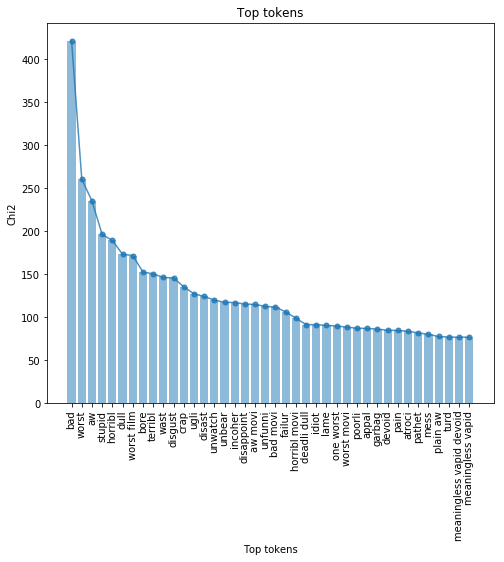

Doing to class: 1


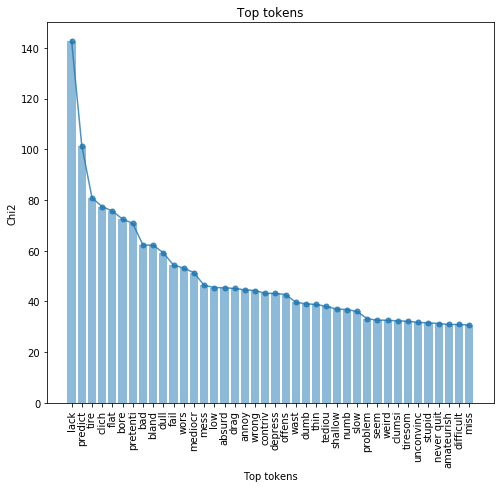

Doing to class: 2


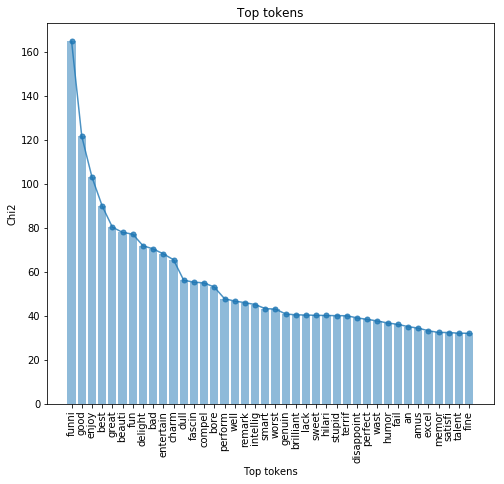

Doing to class: 3


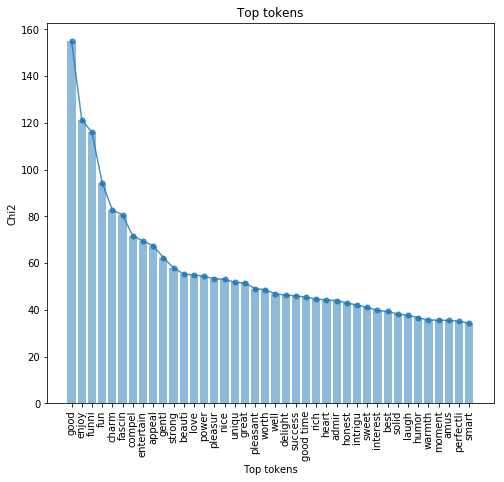

Doing to class: 4


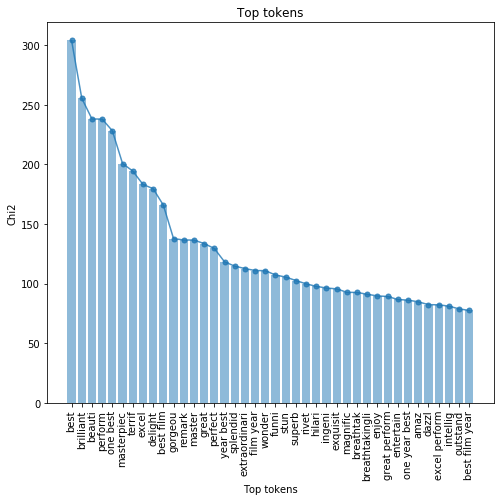

In [9]:
# transform all data equal 1, except target data and plot
for i in range(0,5):
    data_train = pd.DataFrame({"X":x_train_tfidf,"y": y_train})
    data_train.y = data_train.y+10
    inds = sorted(list(data_train.y.value_counts().index))
    
    for j in range(0,len(inds)):
        if i == j:
            data_train.y[data_train['y'] == inds[j]] = 1
        else:
            data_train.y[data_train['y'] == inds[j]] = 0
    print("Doing to class: {}".format(i))
    
    plot_chi2(x_train_tfidf, data_train.y)

# Training First Models

## Train Random Forent Model using chi² features

In [10]:
rf_model = RandomForestClassifier(n_estimators=2)
rf_model.fit(x_train_chi2_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Train Logistic Regression model using chi² features

In [11]:
lr_model = LogisticRegression(random_state=42,
                              solver='lbfgs',
                              multi_class='multinomial').fit(x_train_chi2_selected, y_train)

# Evaluating Models

## Evaluating Random Forest

mean_squared_error: 0.599012457238753
accuracy_score: 0.5999483637771897
              precision    recall  f1-score   support

           0       0.38      0.40      0.39      1414
           1       0.46      0.47      0.47      5451
           2       0.69      0.78      0.73     15705
           3       0.54      0.41      0.46      6575
           4       0.50      0.28      0.36      1841

   micro avg       0.60      0.60      0.60     30986
   macro avg       0.51      0.47      0.48     30986
weighted avg       0.59      0.60      0.59     30986



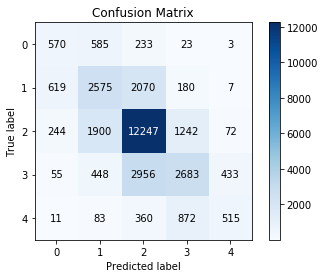

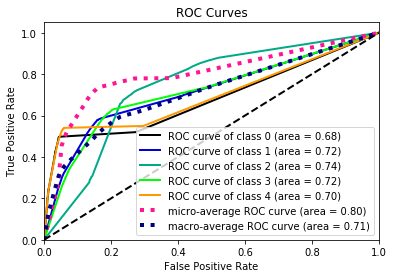

In [12]:
evaluate_model(rf_model,x_validation_chi2_selected, y_validation)

## Evaluating Logistic Regression

mean_squared_error: 0.5339185438585168
accuracy_score: 0.607693797198735
              precision    recall  f1-score   support

           0       0.60      0.18      0.27      1414
           1       0.52      0.30      0.38      5451
           2       0.63      0.89      0.74     15705
           3       0.55      0.39      0.46      6575
           4       0.62      0.22      0.32      1841

   micro avg       0.61      0.61      0.61     30986
   macro avg       0.58      0.39      0.43     30986
weighted avg       0.59      0.61      0.57     30986



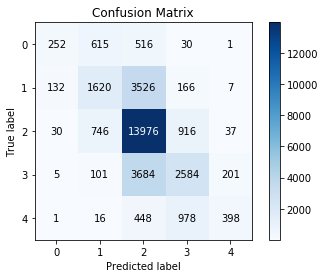

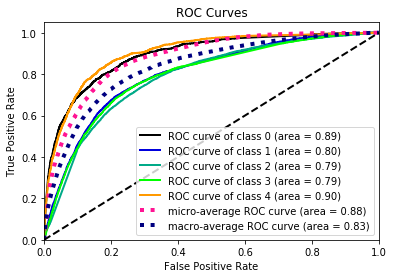

In [13]:
evaluate_model(lr_model,x_validation_chi2_selected, y_validation)

# Train Model Using Randomize Search, to find best Parameters 

The Random Forest Algorithm was selected to perform Randomize Search, mainly due to its Recall, which was superior to Logistic Regression.

## Randomize Search Random Forest

In [14]:
clf = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist = {"n_estimators": [15,25,40,50,70,100],
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 1#30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(x_train_chi2_selected, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 8651.78 seconds for 1 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.636 (std: 0.002)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2, 'n_estimators': 100}



## Train Final Random Forest Model

In [18]:
rf2_model = RandomForestClassifier(bootstrap=True,
                                  criterion='entropy',
                                  max_depth=None,
                                  max_features=5,
                                  min_samples_split=9,
                                  n_estimators=50)
rf2_model.fit(x_train_chi2_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

mean_squared_error: 0.599012457238753
accuracy_score: 0.5999483637771897
              precision    recall  f1-score   support

           0       0.38      0.40      0.39      1414
           1       0.46      0.47      0.47      5451
           2       0.69      0.78      0.73     15705
           3       0.54      0.41      0.46      6575
           4       0.50      0.28      0.36      1841

   micro avg       0.60      0.60      0.60     30986
   macro avg       0.51      0.47      0.48     30986
weighted avg       0.59      0.60      0.59     30986



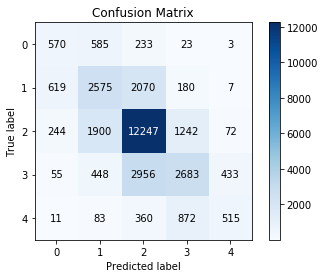

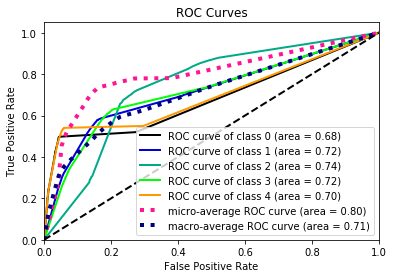

In [19]:
evaluate_model(rf_model,x_validation_chi2_selected, y_validation)

# Saving Models

In [20]:
pickle.dump(rf2_model, open("Sentiment_model_chi.pkl", "wb" ))
pickle.dump(tvec, open("tvec_chi.pkl", "wb" ))
pickle.dump(ch2, open("chi.pkl", "wb" ))

# Observations

In addition to this approach, others were also tested using model pipelines.
Where the model identifies only 3 classes ("positive", "neutral" and "negative") for later separate good into "positive" and "somewhat positive" and do the same with "negative" and "somewhat negative".
However the results were better in some cases and worse in others, thus could not conclude if it was a better approach.
Therefore this approach will be better evaluated and studied in the future.


# References
1. CAO, F. et al. Density-Based Clustering over an Evolving Data Stream with Noise. In: Proceedings of the 6th SIAM International Conference on Data Mining. [S.l.: s.n.], 2006. p. 328–339.
2. BRUM, H. B.; NUNES, M. d. G. V. Building a sentiment corpus of tweets in brazilian portuguese. arXiv preprint arXiv:1712.08917, 2017.